# Infant ASSR Phase Locking

## Introduction
The following analysis pipeline visualizes ASSR phase locking for groups of infants at 2 and 6 months of age.  The pipeline includes a one-time initial loop over infant Epoch files to create Time-Frequency Response (TFR) files.  Subsequent execution of pipeline can skip this creation step and simply load these files to proceed.  Whole-head average gradiometer TFR sequences are computed for each individual, and the age group TFR averages are visualized for power, inter-trial coherence (ITC), and T2circ.  A table of whole-head average TFR stats for three frequencies (centered on the tone frequency) are exported in a tidy-format csv file.
Pipeline computes average response time sequences for a set of seven frequency bands spaced 2 Hz apart, centered on the tone frequency, 40 Hz. The number of cycles used for Morlet TFR analysis are coerced to scale with freq s.t. all passbands have same time window duration. 

### Epoch data file directory paths
The pipeline assumes each input epoch file is located in a project directory following mnefun organization, with a path name like:
>/mnt/scratch/badbaby/tone/bad_116a/epochs/All_100-sss_bad_116a-epo.fif

where the subject id ("116a") has "a" or "b" suffix to indicate 2mo or 6mo visit, respectively.



### Epoch object properties:
```
epo = mne.read_epochs(...)
...
epo.get_data().shape == (120, 306, 781)
[ epo.tmin, epo.tmax ] == [ -0.2, 1.1 ]
epo.time_as_index(0.0) == 120
epo.info['sfreq'] == 600.0
```

### TFR data file directory paths and files
TFR output files are stored all together in one directory, with file names built from the original epoch file name, plus an additional file name suffix to indicate the type of TFR statistic contained in the file. The list of suffixes here corresponds below to the following TFR data variables:
```
tfr_epo.data.shape == (120, 306, 16, 781) # complex-valued tf response
pow_epo.data.shape == (120, 306, 16, 781) # power of  tfr_epo
pow_evo.data.shape == (306, 16, 781) # average power over epochs
itc_evo.data.shape == (306, 16, 781) # inter-trial coherence over epochs
tcirc_evo.data.shape == (306, 16, 781) # T2circ over epochs
```

## Imports

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
from itertools import product as iprod
import matplotlib.pyplot as plt
from scipy.stats import f as f_dist
import mne
from mne.externals.h5io import write_hdf5


## Global definitions
Make sure to run both of these before running any of the file loops below.  You can run the loops to read and visualize as many times as you like, but you must re-run the global definition cells if you subsequently want to re-run the file creation loop.
### Time-frequency response analysis specs

In [18]:
freqs = np.arange(34.0,48.0,2.0)
n_cycles = freqs / 2. # Coerce n_cycles to same time window duration

### input and output path and file name specs

In [17]:
epop = '/mnt/scratch/badbaby/tone/' # project directory used to build mnefun-style epoch file paths
tfrp ='/mnt/scratch/badbaby/pipe/TFRs/' # directory to store output tfr data files, make sure it exists!
tfr_suffixes = [ 'tfr-epo', 'pow-epo', 'pow-evo', 'itc-evo', 't2c-evo']

## Loop over individual Epoch files to create TFR files
Note that this need only be executed once. Once created, the files are read in by the next step in the pipeline, s.t. this node can be skipped.

In [ ]:
# list comprehension to gather epoch file paths from group "a" and "b"
epops = [ sorted(glob(epop + 'bad*'+g+'/epochs/*epo.fif')) for g in ['a', 'b'] ] # get the existing a's and b's
epops = [ epops[0][:3], epops[1][:3] ] # crop for quickie test

for g in epops: # each group
    for sidp in g: # each subject id path
        sid = os.path.basename(sidp)[:-8] # subject id
        
        epo = mne.read_epochs(sidp)
        tNTrl, tNCh, tNS = epo.get_data().shape

        # complex EpochsTFR
        tfr_epo = mne.time_frequency.tfr_morlet( epo, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=False, average=False, output='complex')

        # power EpochsTFR
        pow_epo = mne.time_frequency.tfr_morlet( epo, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=False, average=False, output='power')

        # power and ITC AverageTFR
        pow_evo, itc_evo = mne.time_frequency.tfr_morlet( epo, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, average=True, output='power')

        mofft = np.mean( tfr_epo.data, axis=0 ) # Mean of FFT
        # compute the mean of the variances along real and imaginary axis
        vofft = np.mean( np.stack( ( np.var( np.real(tfr_epo.data), 0 ), np.var( np.imag(tfr_epo.data), 0 ) ) ), 0 )
        numerator = abs(mofft);
        denominator = np.sqrt( vofft / ( tNTrl - 1 ) )
        tcirc = (numerator / denominator)**2
        tcirc_evo = itc_evo.copy()
        tcirc_evo.data = tcirc

        # tuple of time-freq response names and variables to save
        tfr =  tfr_suffixes, [ tfr_epo, pow_epo, pow_evo, itc_evo, tcirc_evo ]
        # Loop to save
        for iv,vn in enumerate(tfr[0]): # tfr[0] is the list of tfr variable names
            tfrvp = tfrp + sid + '_' + vn + '_tfr.h5' # tfr variable path
            tfr[1][iv].save(tfrvp,overwrite=True) # tfr[1] is the list of tfr object variables


## Loops to read and visualize previously created TFR files
If files already exist, pipeline can start with one of the three following TFR visualizations.  Each one specifies a set of three variables:
```
tfrevops = ... # list comprehension to gather tfr evo file paths from group "a" and "b"
tfrevos = ... # AverageTFR objects read from each sid for each group
tfrms = ... # means over sids for each group
```

### Power

In [ ]:
tfrevops = [ sorted(glob(tfrp + 'All*'+g+'_pow-evo_tfr.h5')) for g in ['a', 'b'] ]
tfrevos = [ [ mne.time_frequency.read_tfrs(sidp)[0] for sidp in g ] for g in tfrevops ]
tfrms = [ np.mean( np.stack( [ s.data for s in g ] ), 0 ) for g in tfrevos ]


No baseline correction applied


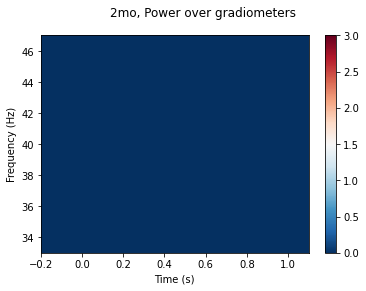

No baseline correction applied


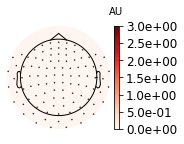

No baseline correction applied


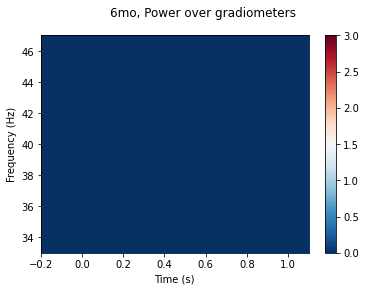

No baseline correction applied


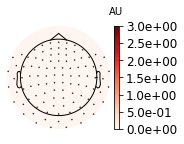

In [20]:
glabs = ['2mo', '6mo']
for ig,g in enumerate(tfrms):
    tfr = tfrevos[0][0].copy()
    tfr.data = g
    tfr.plot(picks='grad',combine='mean',title=glabs[ig]+', Power over gradiometers', vmin=0.0, vmax=3);
    tfr.plot_topomap( ch_type='grad', fmin=38.0,fmax=42.0,tmin=0.5,tmax=1.0,sphere=1.0, vmin=0.0, vmax=3);

### ITC

In [ ]:
tfrevops = [ sorted(glob(tfrp + 'All*'+g+'_itc-evo_tfr.h5')) for g in ['a', 'b'] ]
tfrevos = [ [ mne.time_frequency.read_tfrs(sidp)[0] for sidp in g ] for g in tfrevops ]
tfrms = [ np.mean( np.stack( [ s.data for s in g ] ), 0 ) for g in tfrevos ]

No baseline correction applied


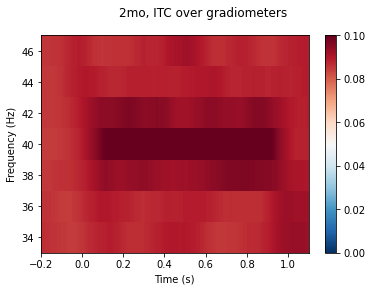

No baseline correction applied


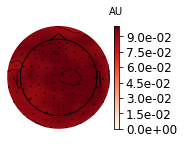

No baseline correction applied


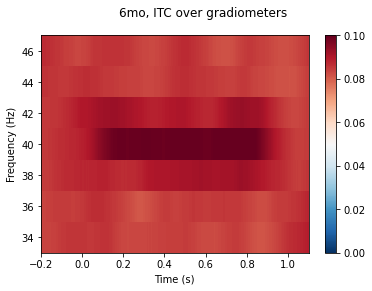

No baseline correction applied


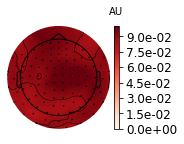

In [22]:
glabs = ['2mo', '6mo']
for ig,g in enumerate(tfrms):
    tfr = tfrevos[0][0].copy()
    tfr.data = g
    tfr.plot(picks='grad',combine='mean',title=glabs[ig]+', ITC over gradiometers', vmin=0.0, vmax=0.1);
    tfr.plot_topomap( ch_type='grad', fmin=38.0,fmax=42.0,tmin=0.5,tmax=1.0,sphere=1.0, vmin=0.0, vmax=0.1);

### T2circ

In [ ]:
tfrevops = [ sorted(glob(tfrp + 'All*'+g+'_t2c-evo_tfr.h5')) for g in ['a', 'b'] ]
tfrevos = [ [ mne.time_frequency.read_tfrs(sidp)[0] for sidp in g ] for g in tfrevops ]
tfrms = [ np.mean( np.stack( [ s.data for s in g ] ), 0 ) for g in tfrevos ]

No baseline correction applied


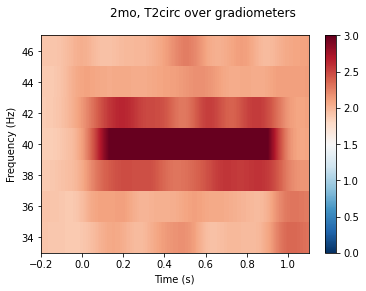

No baseline correction applied


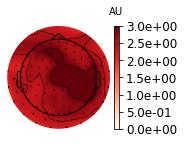

No baseline correction applied


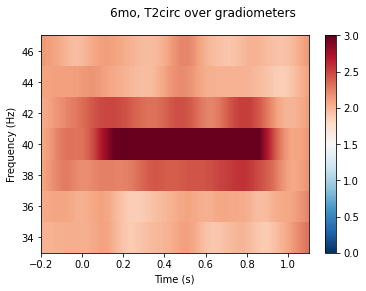

No baseline correction applied


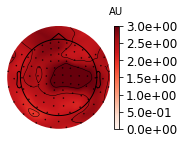

In [24]:
glabs = ['2mo', '6mo']
for ig,g in enumerate(tfrms):
    tfr = tfrevos[0][0].copy()
    tfr.data = g
    tfr.plot(picks='grad',combine='mean',title=glabs[ig]+', T2circ over gradiometers', vmin=0.0, vmax=3);
    tfr.plot_topomap( ch_type='grad', fmin=38.0,fmax=42.0,tmin=0.5,tmax=1.0,sphere=1.0, vmin=0.0, vmax=3);

## Tabulate and save to tidy-format CSV

In [ ]:
# Helper to build pandas DataFrame by recursively nesting dict of categorical key columns
dict2df = lambda d : pd.DataFrame.from_records(iprod(*d.values()),columns=d.keys())

age2gid = { '2mo':'a', '6mo':'b' } # age-to-groupID ('a' and 'b' are parts of file names)
tfr_vnms = [ 'pow', 'itc', 't2c' ] # time-freq response variable names (also part of file name)
fmn,fmx,tmn,tmx = 38.,42.,.2,.8 # freq and time limits (Hz and Sec)

pdfcat = lambda adf : pd.concat(adf,ignore_index=True)
ttab = [] # the table to save
for ia,age in enumerate(age2gid.keys()):
    ttab.append([])
    for tfr in tfr_vnms:
        # hereafter, "sid" is subject id; aslo make sure that "tfrp" has been created above
        sidps = sorted(glob(tfrp+'All*{}_{}-evo_tfr.h5'.format(age2gid[age],tfr))) # sid paths, ...
            # e.g., /mnt/scratch/badbaby/pipe/TFRs/All_100-sss_bad_921b_t2c-evo_tfr.h5
        # sidps = sidps[:4] # shorty version for quick testing
        sids = [ os.path.basename(sidp)[-19:-15] for sidp in sidps ] # get id from full path
        tfrevos = [ mne.time_frequency.read_tfrs(sidp)[0] for sidp in sidps ] # tfr evo objects read from each path
        fps = [f >= fmn and f <= fmx for f in tfrevos[0].freqs] # frequency picks QC: should be [38.0, 40.0, 42.0]
        tps = [ t >= tmn and t < tmx for t in tfrevos[0].times ] # time picks
        freqs = tfrevos[0].freqs[fps] # the picked frequencies, for labeling
        # for this tfr variable, calc mean over grads and tps for each sid... 
        tfrdvs = np.concatenate( [ np.mean(np.mean(atfr.copy().pick('grad').data[:,:,tps],-1),0)[fps]
            for atfr in tfrevos ] ) # then stack the three fps from all the sids
        # make dataframe key fields
        df = dict2df( { 'age':[age], 'sid':sids, 'tfrvar':[tfr], 'freqs':freqs } )
        df['tfrval'] = tfrdvs # add data field
        ttab[ia].append(df) # append data frame to table
    ttab[ia]=pd.concat(ttab[ia],ignore_index=True) # stack the dfs from the different tfr variables
ttab=pd.concat(ttab,ignore_index=True) # stack the two age groups
ttab.to_csv('tfr_stats1.csv') # save in csv format in local directory
